In [2]:
# for basic operations
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
df = pd.read_csv("data/df.csv")

df.head()

,product_id,product_type,product_name,size,colour,price,quantity_available_product,description,customer_id,gender,...,quantity_product_sales,total_price,profit_per_product (dollar),total_profit (dollars),discount_per_product,profit_per_product_official,season,delivery_time (days),year_month,sales
0,218,Shirt,Chambray,L,orange,105,44,"A orange coloured, L sized, Chambray Shirt",64,Genderfluid,...,2,212,1,2,0.00,0.95,Winter,25,2021-08-01,4620
1,481,Jacket,Puffer,S,indigo,110,62,"A indigo coloured, S sized, Puffer Jacket",64,Genderfluid,...,1,118,8,8,0.00,7.27,Winter,25,2021-08-01,6820
2,2,Shirt,Oxford Cloth,M,red,114,54,"A red coloured, M sized, Oxford Cloth Shirt",64,Genderfluid,...,3,288,0,0,15.79,0.00,Winter,25,2021-08-01,6156
3,1002,Trousers,Wool,M,blue,111,52,"A blue coloured, M sized, Wool Trousers",64,Genderfluid,...,2,212,0,0,4.50,0.00,Winter,25,2021-08-01,5772
4,691,Jacket,Parka,S,indigo,119,53,"A indigo coloured, S sized, Parka Jacket",64,Genderfluid,...,3,339,0,0,5.04,0.00,Winter,25,2021-08-01,6307


# 1. Customer Segmentation

## 1.1 Agglomerative Clustering

### 1.1.1 Data Preprocessing

In [5]:
df_clust = df.copy()

**RFM And Other Customer Attrribute Table**

In [25]:
# Convert to show date only
df_clust["order_date"] = pd.to_datetime(df_clust["order_date"]).dt.date

# Create date variable that records recency
import datetime
snapshot_date = max(df_clust.order_date) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_clust.groupby('customer_id').agg(
            Recency = ('order_date', lambda x: (snapshot_date - x.max()).days),
            Frequency = ('order_id', 'nunique'),
            MonetaryValue = ('total_price', 'sum'),
            UniqueProduct = ('product_type', 'nunique'),
            FrequentlyPurchasedProduct = ('product_type', lambda x:x.value_counts().index[0]),
            Gender = ('gender', lambda x:x.value_counts().index[0]),
            Age = ('age', 'mean'),
            State = ('state', lambda x:x.value_counts().index[0]),
            Discount = ('discount_per_product', 'mean'),
            Season = ('season', lambda x:x.value_counts().index[0]),
            UniqueSeason = ('season', 'nunique'),
            DeliveryTime = ('delivery_time (days)', lambda x:x.value_counts().index[0])
)

In [26]:
customers

,Recency,Frequency,MonetaryValue,UniqueProduct,FrequentlyPurchasedProduct,Gender,Age,State,Discount,Season,UniqueSeason,DeliveryTime
customer_id,,,,,,,,,,,,
1,204,8,1641,2,Jacket,Female,30.0,Northern Territory,14.010000,Autumn,2,26
7,157,5,1017,3,Trousers,Bigender,76.0,Queensland,0.900000,Autumn,1,2
10,230,1,270,1,Trousers,Bigender,70.0,Western Australia,5.260000,Autumn,1,20
11,150,2,382,2,Shirt,Agender,39.0,Northern Territory,10.775000,Autumn,1,8
12,128,8,1551,3,Jacket,Bigender,78.0,South Australia,7.841250,Winter,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...
994,286,7,1716,3,Shirt,Female,53.0,Western Australia,12.658571,Summer,1,22
995,84,10,2140,3,Shirt,Polygender,63.0,Western Australia,10.514000,Winter,1,15
996,52,13,3045,3,Jacket,Agender,59.0,Tasmania,5.334615,Autumn,2,3


**Feature Encoding**

In [27]:
customers.select_dtypes(exclude=['number']).columns

Index(['FrequentlyPurchasedProduct', 'Gender', 'State', 'Season'], dtype='object')

In [28]:
customers.select_dtypes(include=['number']).columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'UniqueProduct', 'Age',
       'Discount', 'UniqueSeason', 'DeliveryTime'],
      dtype='object')

In [29]:
customers_std = customers.copy()

In [30]:
# One-hot Encoding
def onehot_encode(data, column):
    dummies = pd.get_dummies(data[column], prefix=column)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

for column in ['FrequentlyPurchasedProduct', 'Gender', 'State', 'Season']:
        customers_std = onehot_encode(customers_std, column=column)

**Standardisation**

In [31]:
from sklearn.preprocessing import StandardScaler

std_columns = ['Recency', 'Frequency', 'MonetaryValue', 'UniqueProduct', 'Age', 'Discount', 'UniqueSeason', 'DeliveryTime']

for i in std_columns:
    customers_std[i] = StandardScaler().fit_transform(customers_std[i].values.reshape(len(customers_std),1))

In [32]:
customers_std.head(3)

,Recency,Frequency,MonetaryValue,UniqueProduct,Age,Discount,UniqueSeason,DeliveryTime,FrequentlyPurchasedProduct_Jacket,FrequentlyPurchasedProduct_Shirt,...,State_Northern Territory,State_Queensland,State_South Australia,State_Tasmania,State_Victoria,State_Western Australia,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.955770,-0.022877,-0.031810,-1.138659,-1.109676,2.389811,0.901852,1.537046,1,0,...,1,0,0,0,0,0,1,0,0,0
7,0.397957,-0.610061,-0.615612,0.601822,1.529332,-1.598533,-0.671918,-1.576641,0,0,...,0,1,0,0,0,0,1,0,0,0
10,1.264348,-1.392973,-1.314490,-2.879140,1.185114,-0.272127,-0.671918,0.758624,0,0,...,0,0,0,0,0,1,1,0,0,0


### 1.1.2 Determine Cluster Number

**Import some necessary libraries**

In [33]:
from sklearn.cluster import AgglomerativeClustering # For HAC clustering
import scipy.cluster.hierarchy as sch # For HAC Denddrogram

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

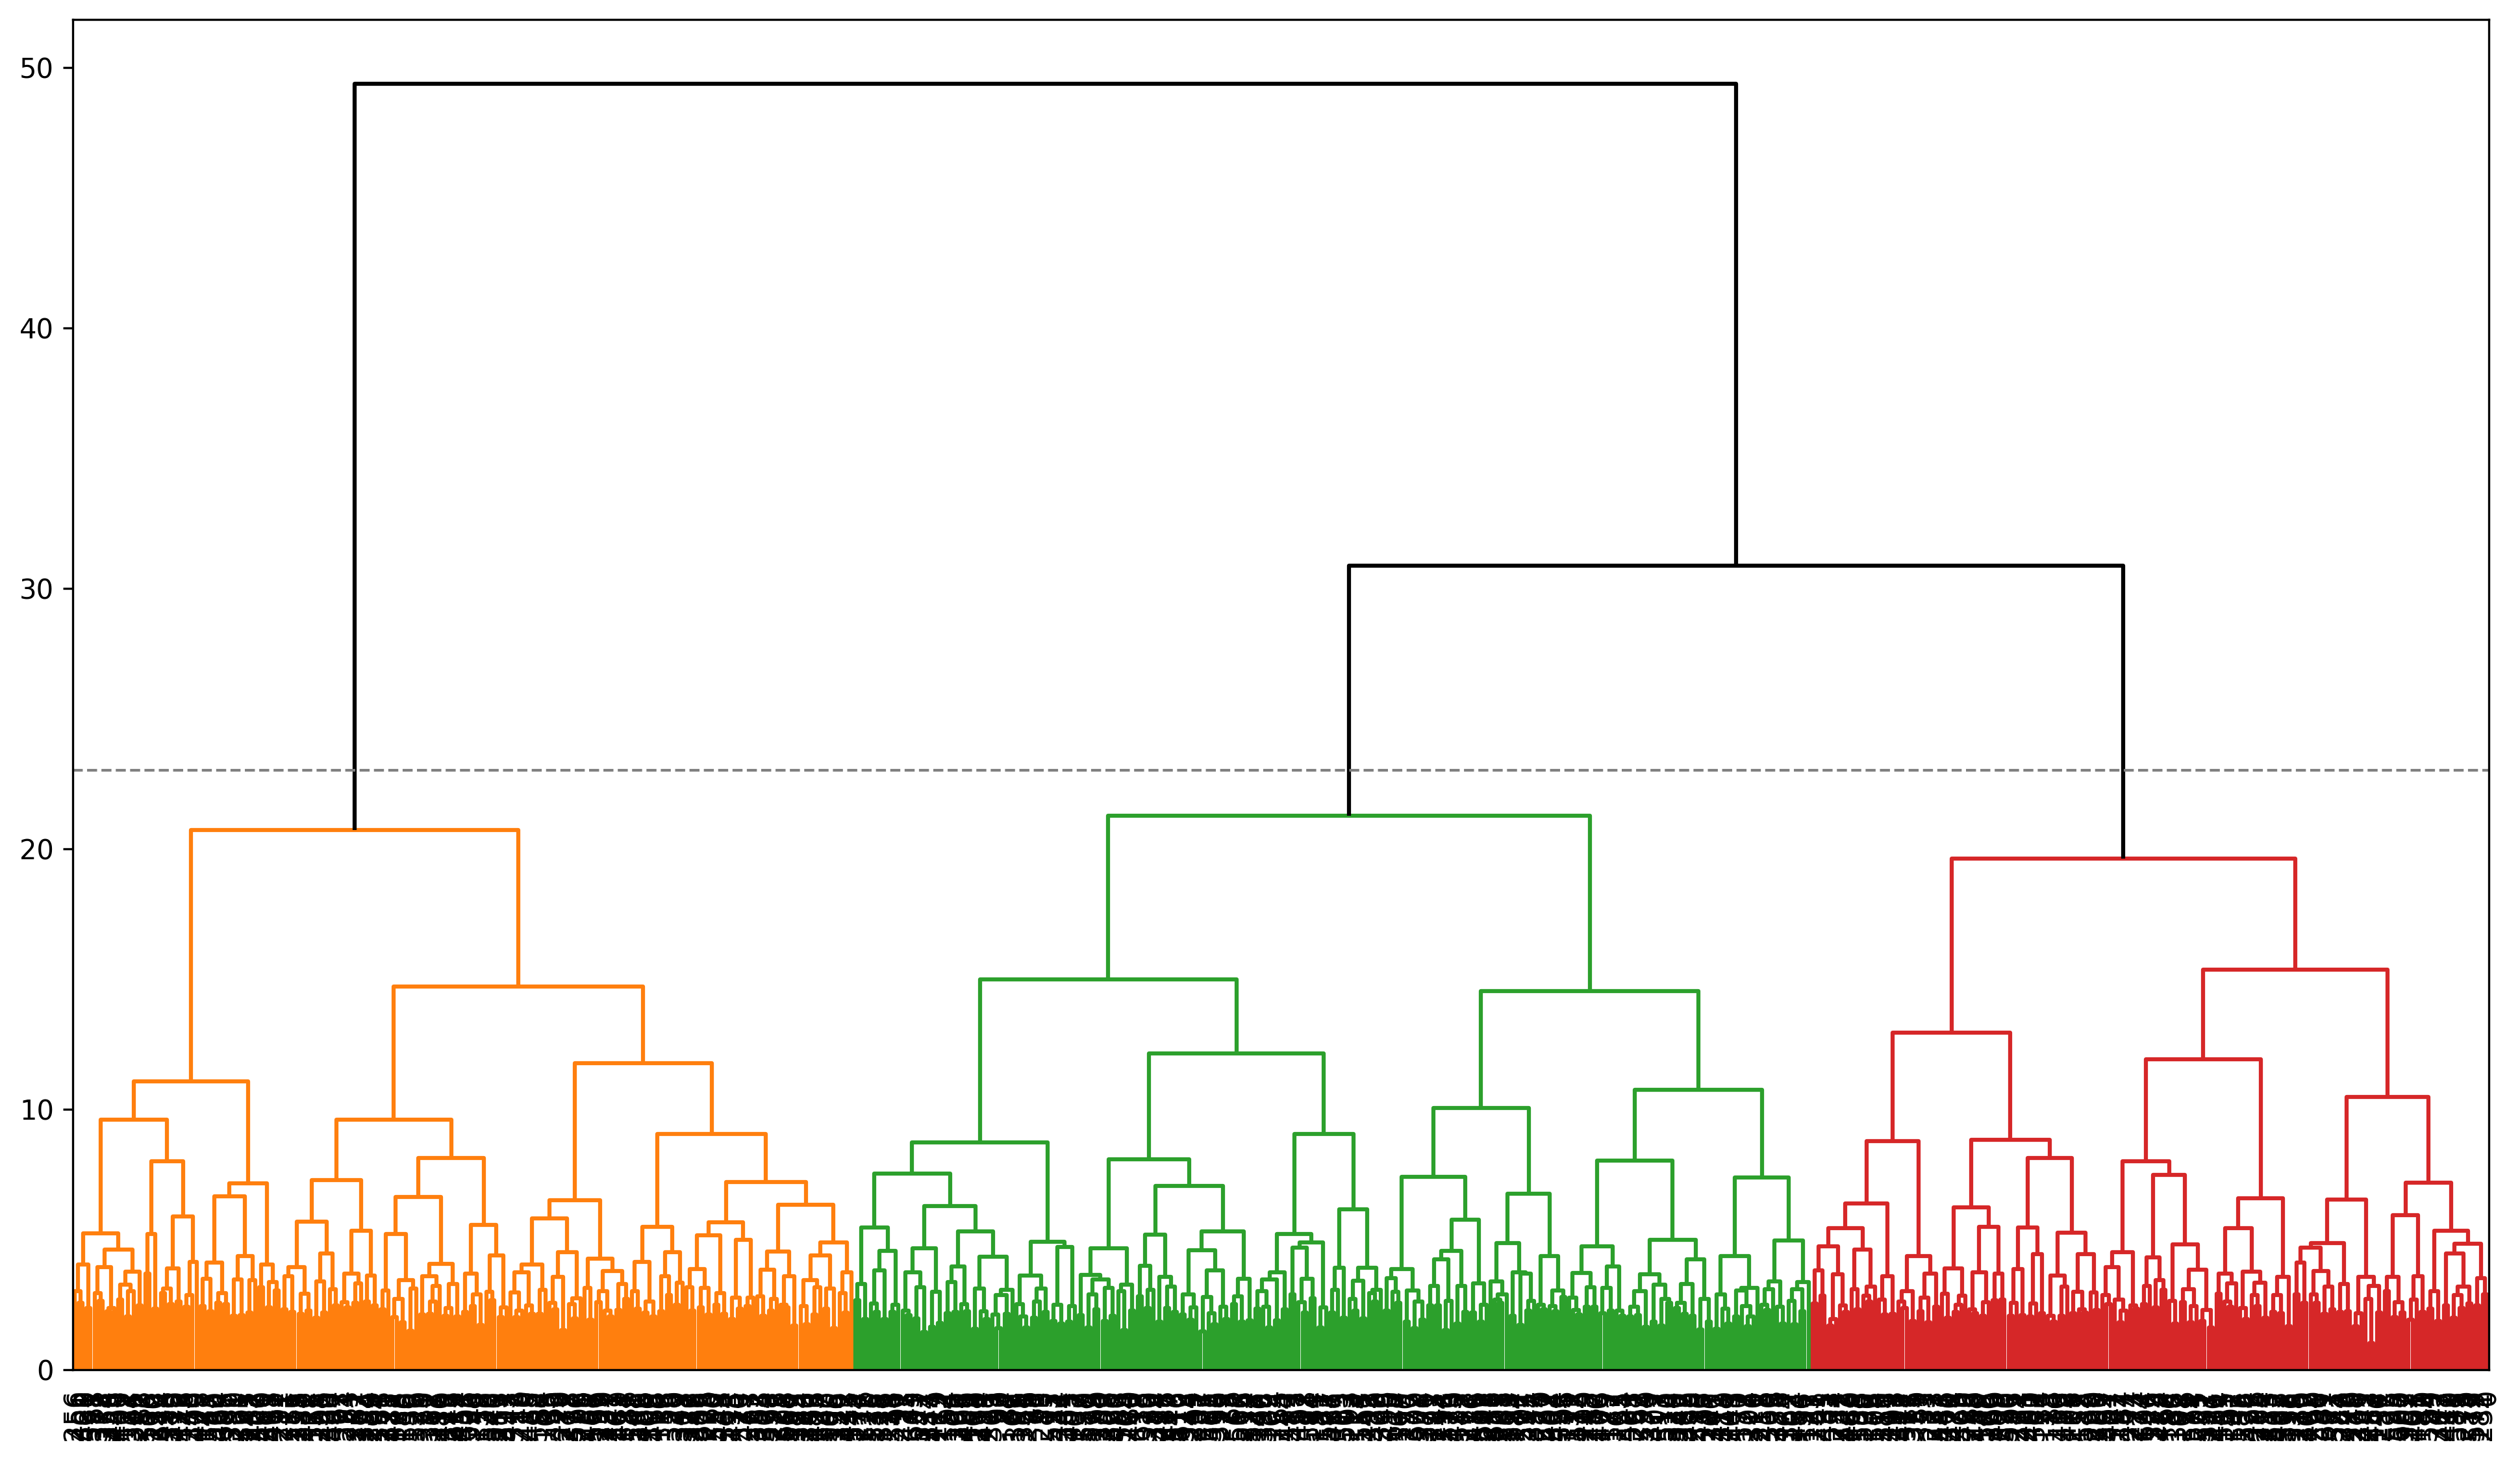

In [34]:
# Select attributes
X = customers_std

# Create a figure
plt.figure(figsize=(16,9), dpi=300)

# Create linkage
Z = sch.linkage(X, method='ward', optimal_ordering=True)

# Draw a dendrogram
sch.dendrogram(Z, leaf_rotation=90, leaf_font_size=10,
               color_threshold=23, above_threshold_color='black')

# Add horizontal line
plt.axhline(y=23, c='grey', lw=1, linestyle='dashed')

# Show the plot
plt.show()

### 1.1.3 Modelling

In [35]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
clust = model.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [36]:
customers_std['clusters'] = clust.labels_
customers['clusters'] = clust.labels_

In [37]:
customers.head()

,Recency,Frequency,MonetaryValue,UniqueProduct,FrequentlyPurchasedProduct,Gender,Age,State,Discount,Season,UniqueSeason,DeliveryTime,clusters
customer_id,,,,,,,,,,,,,
1,204,8,1641,2,Jacket,Female,30.0,Northern Territory,14.01000,Autumn,2,26,2
7,157,5,1017,3,Trousers,Bigender,76.0,Queensland,0.90000,Autumn,1,2,0
10,230,1,270,1,Trousers,Bigender,70.0,Western Australia,5.26000,Autumn,1,20,2
11,150,2,382,2,Shirt,Agender,39.0,Northern Territory,10.77500,Autumn,1,8,2
12,128,8,1551,3,Jacket,Bigender,78.0,South Australia,7.84125,Winter,1,12,0


### 1.1.4 Interpret The Segment

In [38]:
customers.groupby(['clusters'])['Recency','Frequency','MonetaryValue'].agg(['mean','count']).T

<ipython-input-38-ed8af0f86177>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  customers.groupby(['clusters'])['Recency','Frequency','MonetaryValue'].agg(['mean','count']).T


clusters                       0            1           2
Recency       mean    140.393443    83.216080  145.901734
              count   244.000000   199.000000  173.000000
Frequency     mean      6.893443    13.396985    3.768786
              count   244.000000   199.000000  173.000000
MonetaryValue mean   1431.557377  2764.211055  765.445087
              count   244.000000   199.000000  173.000000

In [39]:
customers.groupby(['clusters','FrequentlyPurchasedProduct'])['clusters'].agg(['count'])

count
clusters FrequentlyPurchasedProduct       
0        Jacket                         82
         Shirt                          77
         Trousers                       85
1        Jacket                         72
         Shirt                          59
         Trousers                       68
2        Jacket                         66
         Shirt                          49
         Trousers                       58

In [40]:
customers.groupby(['clusters','Season'])['clusters'].agg(['count'])

count
clusters Season       
0        Autumn     68
         Spring     45
         Summer     42
         Winter     89
1        Autumn     64
         Spring     34
         Summer     48
         Winter     53
2        Autumn     59
         Spring     28
         Summer     30
         Winter     56

<ipython-input-41-8ceb9d2151f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['ID'] = customers.index
<ipython-input-41-8ceb9d2151f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['Cluster'] = clust.labels_


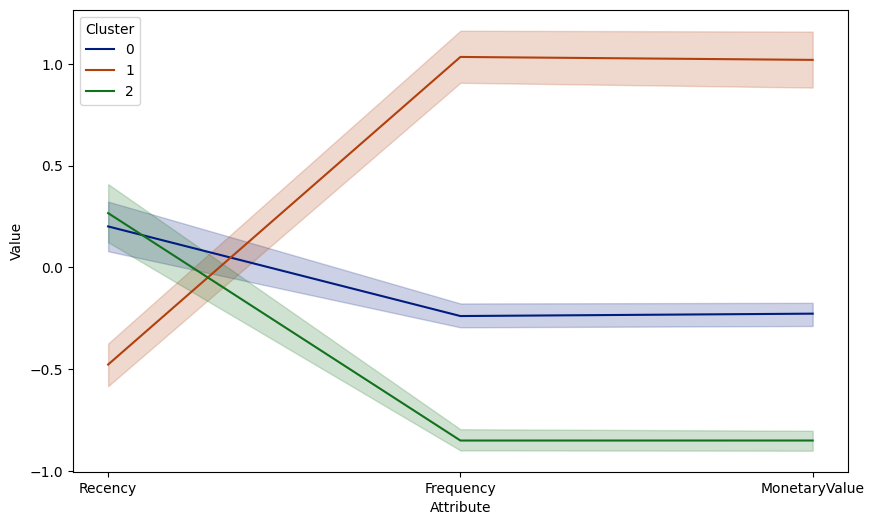

In [41]:
# Create the dataframe
df_normalized = customers_std[['Recency', 'Frequency', 'MonetaryValue']]
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = clust.labels_

# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

# Visualize it
plt.figure(figsize=(10,6))
sns.lineplot(x = 'Attribute', y = 'Value', hue='Cluster', palette='dark', data=df_nor_melt)
plt.show()

<ipython-input-43-ba8c06343c5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['ID'] = customers.index
<ipython-input-43-ba8c06343c5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['Cluster'] = clust.labels_


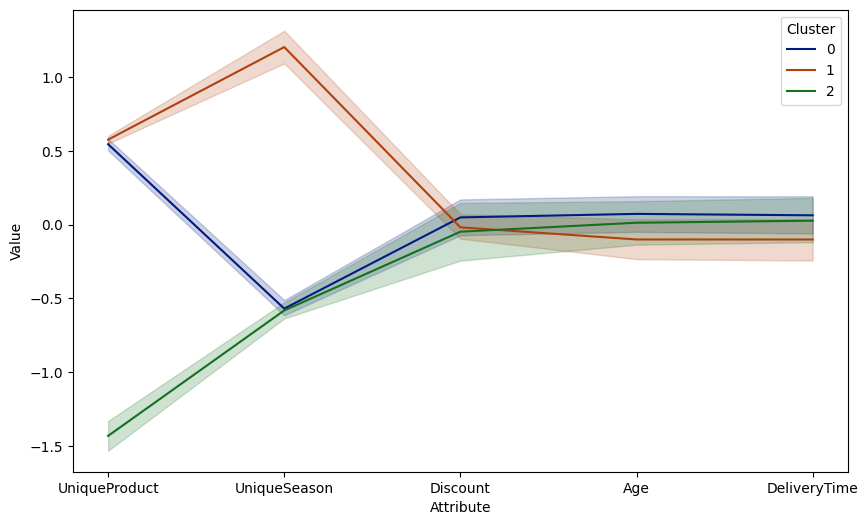

In [43]:
# Create the dataframe
df_normalized = customers_std[['UniqueProduct', 'UniqueSeason', 'Discount', 'Age', 'DeliveryTime']]
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = clust.labels_

# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['UniqueProduct', 'UniqueSeason', 'Discount', 'Age', 'DeliveryTime'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

# Visualize it
plt.figure(figsize=(10,6))
sns.lineplot(x = 'Attribute', y = 'Value', hue='Cluster', palette='dark', data=df_nor_melt)
plt.show()

1. cluster 0: **loyal customer**
- buy the product recently
- most frequent
- spend more
- varied products
- does not depend on season
- frequently purchased product is jacket
- most deals are in winter
2. cluster 1: **need-based customer**
- buy the product at the old time
- less frequent
- moderate to spend
- varied products
- season is likely to affect
- frequently purchased product is trousers
- most deals are in winter
3. cluster 2: **churned customer**
- buy the product at the old time
- least frequent
- least to spend
- invariable products
- season is likely to affect
- frequently purchased product is jacket
- most deals are in winter

> _discount, age, delivery time tend to have no effect._

In [64]:
customers_notunique = df_clust.groupby('customer_id').agg(
            Recency = ('order_date', lambda x: (snapshot_date - x.max()).days),
            Frequency = ('order_id', 'count'),
            MonetaryValue = ('total_price', 'sum'),
)

<ipython-input-65-eb4b563e8374>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'], color="royalblue")
<ipython-input-65-eb4b563e8374>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'], color='royalblue')
<ipyth

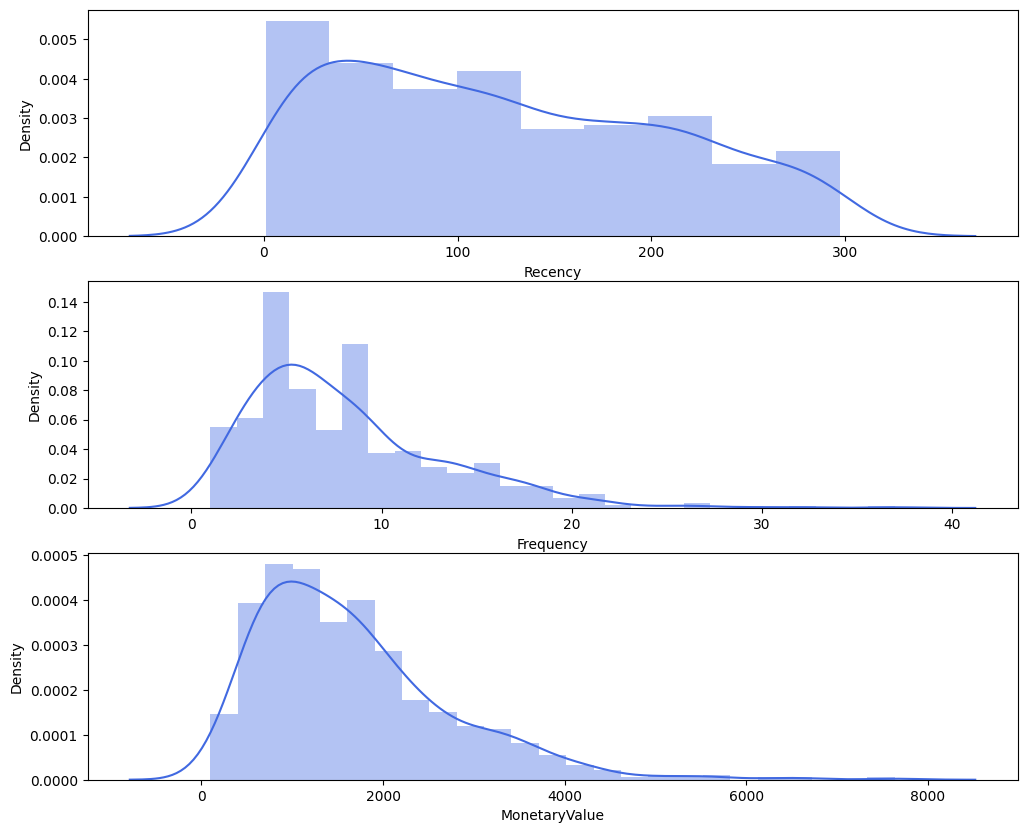

In [65]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers['Recency'], color="royalblue")
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'], color='royalblue')
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'], color="royalblue")
# Show the plot
plt.show()

In [68]:
quantile = customers_notunique.quantile(q=[0.3, 0.7])
quantile

,Recency,Frequency,MonetaryValue
0.3,62.0,5.0,979.0
0.7,175.0,9.0,2015.5


In [69]:
quantile.to_dict()

{'Recency': {0.3: 62.0, 0.7: 175.0},
 'Frequency': {0.3: 5.0, 0.7: 9.0},
 'MonetaryValue': {0.3: 979.0, 0.7: 2015.5}}

In [70]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.3]:
        return 3
    elif x <= d[p][0.7]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.3]:
        return 1
    elif x <= d[p][0.7]:
        return 2
    else:
        return 3

In [73]:
RFM_Segmentation = customers_notunique
RFM_Segmentation['R_Score'] = RFM_Segmentation['Recency'].apply(RScore, args=('Recency',quantile))
RFM_Segmentation['F_Score'] = RFM_Segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
RFM_Segmentation['M_Score'] = RFM_Segmentation['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantile))

In [74]:
RFM_Segmentation.head()

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score
customer_id,,,,,,
1,204,8,1641,1,2,2
7,157,5,1017,2,1,2
10,230,1,270,1,1,1
11,150,2,382,2,1,1
12,128,8,1551,2,2,2


In [75]:
RFM_Segmentation.describe()

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,123.469156,8.116883,1675.000000,2.001623,1.933442,2.000000
std,84.326017,5.113283,1069.724092,0.776691,0.810772,0.775646
min,1.000000,1.000000,100.000000,1.000000,1.000000,1.000000
25%,51.750000,4.000000,878.250000,1.000000,1.000000,1.000000
50%,111.500000,7.000000,1439.000000,2.000000,2.000000,2.000000
75%,192.000000,10.000000,2165.000000,3.000000,3.000000,3.000000
max,297.000000,37.000000,7632.000000,3.000000,3.000000,3.000000


In [77]:
RFM_Segmentation['RFM_Score'] = RFM_Segmentation.R_Score.map(str) \
                            + RFM_Segmentation.F_Score.map(str) \
                            + RFM_Segmentation.M_Score.map(str)

In [79]:
# Define RFM Segmentation function
def RFM_Segment(df):
  if df['RFM_Score'] == '333':
    return 'Champions'
  elif df['RFM_Score'] == '332':
    return 'Champions'
  elif df['RFM_Score'] == '331':
    return 'Potential High Customer'
  elif df['RFM_Score'] == '323':
    return 'Champions'
  elif df['RFM_Score'] == '322':
    return 'Potential High Customer'
  elif df['RFM_Score'] == '321':
    return 'General Customer'
  elif df['RFM_Score'] == '313':
    return 'General Customer'
  elif df['RFM_Score'] == '312':
    return 'General Customer'
  elif df['RFM_Score'] == '311':
    return 'General Customer'
  elif df['RFM_Score'] == '233':
    return 'Champions'
  elif df['RFM_Score'] == '232':
    return 'Potential High Customer'
  elif df['RFM_Score'] == '231':
    return 'General Customer'
  elif df['RFM_Score'] == '223':
    return 'Potential High Customer'
  elif df['RFM_Score'] == '222':
    return 'General Customer'
  elif df['RFM_Score'] == '221':
    return 'About to Sleep'
  elif df['RFM_Score'] == '213':
    return 'General Customer'
  elif df['RFM_Score'] == '212':
    return 'About to Sleep'
  elif df['RFM_Score'] == '211':
    return 'About to Sleep'
  elif df['RFM_Score'] == '133':
    return 'Customer Needing Attention'
  elif df['RFM_Score'] == '132':
    return 'Customer Needing Attention'
  elif df['RFM_Score'] == '131':
    return 'About to Sleep'
  elif df['RFM_Score'] == '123':
    return 'Customer Needing Attention'
  elif df['RFM_Score'] == '122':
    return 'Customer Needing Attention'
  elif df['RFM_Score'] == '121':
    return 'About to Sleep'
  elif df['RFM_Score'] == '113':
    return 'About to Sleep'
  elif df['RFM_Score'] == '112':
    return 'About to Sleep'
  else:
    return 'About to Sleep'

# Create a new variable RFM_Segment
RFM_Segmentation['RFM_Segment'] = RFM_Segmentation.apply(RFM_Segment, axis=1)
# Print the header with top 5 rows to the console
RFM_Segmentation.head()

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
customer_id,,,,,,,,
1,204,8,1641,1,2,2,122,Customer Needing Attention
7,157,5,1017,2,1,2,212,About to Sleep
10,230,1,270,1,1,1,111,About to Sleep
11,150,2,382,2,1,1,211,About to Sleep
12,128,8,1551,2,2,2,222,General Customer


In [80]:
# Best Clients
RFM_Segmentation[RFM_Segmentation['RFM_Score'] == '333'].sort_values('MonetaryValue', ascending=False).head(10)

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
customer_id,,,,,,,,
664,21,29,6341,3,3,3,333,Champions
566,6,26,5435,3,3,3,333,Champions
348,25,26,5119,3,3,3,333,Champions
813,31,21,4969,3,3,3,333,Champions
727,4,21,4428,3,3,3,333,Champions
129,17,21,4399,3,3,3,333,Champions
107,17,20,4385,3,3,3,333,Champions
732,18,18,4240,3,3,3,333,Champions
623,26,20,4214,3,3,3,333,Champions


In [81]:
# Calculate average values for each RFM_Segment, and return a size of each segment
RFM_level_agg = RFM_Segmentation.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(RFM_level_agg)

                           Recency Frequency MonetaryValue      
                              mean      mean          mean count
RFM_Segment                                                     
About to Sleep               175.4       3.7         755.1   184
Champions                     62.6      14.7        3025.4   151
Customer Needing Attention   228.4       9.2        1918.1    91
General Customer              81.4       5.8        1208.3   119
Potential High Customer       54.3       7.9        1657.7    71


In [83]:
RFM_Segmentation["RFM_Segment"].value_counts()

About to Sleep                184
Champions                     151
General Customer              119
Customer Needing Attention     91
Potential High Customer        71
Name: RFM_Segment, dtype: int64

<Axes: title={'center': 'RFM_Segment'}>

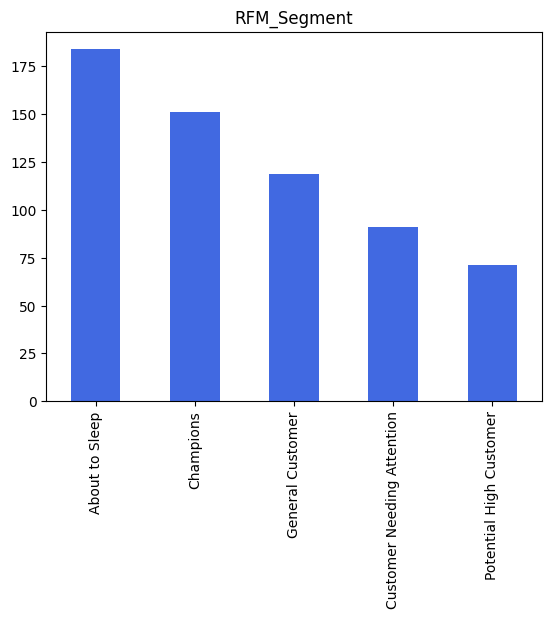

In [84]:
RFM_Segmentation['RFM_Segment'].value_counts().plot(kind='bar', title='RFM_Segment', color='royalblue')

In [85]:
RFM_df = RFM_Segmentation.drop(['Recency', 'Frequency', 'MonetaryValue', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score'], axis=1)
RFM_df

,RFM_Segment
customer_id,
1,Customer Needing Attention
7,About to Sleep
10,About to Sleep
11,About to Sleep
12,General Customer
...,...
994,Customer Needing Attention
995,Champions
996,Champions


In [62]:
RFM_df["RFM_Segment"].value_counts()

About to Sleep                184
Champions                     151
General Customer              119
Customer Needing Attention     91
Potential High Customer        71
Name: RFM_Segment, dtype: int64

In [ ]:
# Left join the dataframe
df_RFM = pd.merge(df_clust,RFM_df,on='customer_id',how='left')
df_RFM

In [87]:
df_RFM["RFM_Segment"].value_counts()

Champions                     2223
Customer Needing Attention     835
General Customer               692
About to Sleep                 686
Potential High Customer        564
Name: RFM_Segment, dtype: int64

In [88]:
df_RFM.groupby(['RFM_Segment']).agg(['mean','min','max','std'])

<ipython-input-88-b1b49c5aaeed>:1: FutureWarning: ['product_type', 'product_name', 'size', 'colour', 'description', 'gender', 'city', 'state', 'order_date', 'delivery_date', 'season', 'year_month'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_RFM.groupby(['RFM_Segment']).agg(['mean','min','max','std'])


product_id                             price      \
                                  mean min   max         std        mean min   
RFM_Segment                                                                    
About to Sleep              642.188047   1  1259  355.865879  105.594752  90   
Champions                   633.428250   1  1259  363.658350  105.804318  90   
Customer Needing Attention  632.314970   1  1256  361.355807  105.366467  90   
General Customer            644.382948   7  1259  366.210337  105.804913  90   
Potential High Customer     616.521277   2  1257  370.231949  105.475177  90   

                                           quantity_available_product      \
                            max        std                       mean min   
RFM_Segment                                                                 
About to Sleep              119   9.856884                  60.278426  40   
Champions                   119   9.646681                  59.956815  40   
Customer Needing Attention  119   9.839471                  59.864671  40   
General Customer            119   9.550283                  60.349711  40   
Potential High Customer     119  10.022945                  60.342199  40   

                            ... profit_per_product_official            \
                            ...                         max       std   
RFM_Segment                 ...                                         
About to Sleep              ...                       23.16  7.552498   
Champions                   ...                       23.16  7.556051   
Customer Needing Attention  ...                       23.16  7.460896   
General Customer            ...                       23.16  7.703396   
Potential High Customer     ...                       23.16  7.821497   

                           delivery_time (days)                    \
                                           mean min max       std   
RFM_Segment                                                         
About to Sleep                        13.370262   1  27  7.827889   
Champions                             13.738192   1  27  7.600382   
Customer Needing Attention            14.138922   1  27  7.420230   
General Customer                      14.861272   1  27  7.726576   
Potential High Customer               14.448582   1  27  7.900526   

                                  sales                           
                                   mean   min   max          std  
RFM_Segment                                                       
About to Sleep              6373.774052  3600  9520  1436.875656  
Champions                   6351.417454  3600  9520  1393.097078  
Customer Needing Attention  6317.730539  3600  9520  1421.701043  
General Customer            6394.066474  3690  9520  1413.580795  
Potential High Customer     6378.505319  3600  9520  1433.073416  

[5 rows x 64 columns]

In [89]:
# create a list of our conditions
conditions = [
    (df_RFM['age'] <= 24),
    (df_RFM['age'] > 24) & (df_RFM['age'] <= 40),
    (df_RFM['age'] > 40) & (df_RFM['age'] <= 55),
    (df_RFM['age'] > 55)
    ]

# create a list of the values we want to assign for each condition
values = ['Gen_Z','Gen_Milenial','Gen_X','Baby_Boomer']

# create a new column and use np.select to assign values to it using our lists as arguments
df_RFM['Generation'] = np.select(conditions, values)

# display updated DataFrame
df_RFM.head()


,product_id,product_type,product_name,size,colour,price,quantity_available_product,description,customer_id,gender,...,profit_per_product (dollar),total_profit (dollars),discount_per_product,profit_per_product_official,season,delivery_time (days),year_month,sales,RFM_Segment,Generation
0,218,Shirt,Chambray,L,orange,105,44,"A orange coloured, L sized, Chambray Shirt",64,Genderfluid,...,1,2,0.00,0.95,Winter,25,2021-08-01,4620,Potential High Customer,Baby_Boomer
1,481,Jacket,Puffer,S,indigo,110,62,"A indigo coloured, S sized, Puffer Jacket",64,Genderfluid,...,8,8,0.00,7.27,Winter,25,2021-08-01,6820,Potential High Customer,Baby_Boomer
2,2,Shirt,Oxford Cloth,M,red,114,54,"A red coloured, M sized, Oxford Cloth Shirt",64,Genderfluid,...,0,0,15.79,0.00,Winter,25,2021-08-01,6156,Potential High Customer,Baby_Boomer
3,1002,Trousers,Wool,M,blue,111,52,"A blue coloured, M sized, Wool Trousers",64,Genderfluid,...,0,0,4.50,0.00,Winter,25,2021-08-01,5772,Potential High Customer,Baby_Boomer
4,691,Jacket,Parka,S,indigo,119,53,"A indigo coloured, S sized, Parka Jacket",64,Genderfluid,...,0,0,5.04,0.00,Winter,25,2021-08-01,6307,Potential High Customer,Baby_Boomer


In [90]:
df_age = df_RFM.groupby(['RFM_Segment','Generation'])['customer_id'].count()
pd.DataFrame(data=df_age).sort_values(by=['RFM_Segment','customer_id'], ascending=False)

customer_id
RFM_Segment                Generation               
Potential High Customer    Baby_Boomer           284
                           Gen_X                 124
                           Gen_Milenial           95
                           Gen_Z                  61
General Customer           Baby_Boomer           261
                           Gen_X                 201
                           Gen_Milenial          160
                           Gen_Z                  70
Customer Needing Attention Baby_Boomer           334
                           Gen_Milenial          250
                           Gen_X                 201
                           Gen_Z                  50
Champions                  Baby_Boomer           825
                           Gen_Milenial          705
                           Gen_X                 469
                           Gen_Z                 224
About to Sleep             Baby_Boomer           254
                           Gen_Milenial          188
                           Gen_X                 188
                           Gen_Z                  56

Recommendations:
Increase sales for gen x and gen z

In [92]:
# Client frequency
Freq_Client_df = RFM_Segmentation.drop(['Recency', 'MonetaryValue', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score'], axis=1)
Freq_Client_df

,Frequency,RFM_Segment
customer_id,,
1,8,Customer Needing Attention
7,5,About to Sleep
10,1,About to Sleep
11,2,About to Sleep
12,8,General Customer
...,...,...
994,7,Customer Needing Attention
995,10,Champions
996,13,Champions


In [93]:
groups = df_RFM.groupby("customer_id")["total_price"].sum()
groups2 = groups.nlargest(5)
groups2

customer_id
282    7632
571    6640
664    6341
683    5657
206    5581
Name: total_price, dtype: int64

In [94]:
# Top spender and their segment
Top_spender = pd.merge(Freq_Client_df,groups2, on='customer_id',how='right')
Top_spender

,Frequency,RFM_Segment,total_price
customer_id,,,
282,32,Champions,7632
571,37,Champions,6640
664,29,Champions,6341
683,26,Champions,5657
206,23,Champions,5581


In [95]:
# Most Loyal client and their segment
Loyal_client = pd.merge(Freq_Client_df,groups2, on='customer_id',how='right')
Most_loyal_client = Loyal_client.drop(['total_price'], axis=1)
Most_loyal_client.sort_values(by=['Frequency'], ascending=False)

,Frequency,RFM_Segment
customer_id,,
571,37,Champions
282,32,Champions
664,29,Champions
683,26,Champions
206,23,Champions


In [100]:
df_RFM['product'] = df_RFM['product_type'] + "-" + df_RFM['product_name']
df_RFM

,product_id,product_type,product_name,size,colour,price,quantity_available_product,description,customer_id,gender,...,total_profit (dollars),discount_per_product,profit_per_product_official,season,delivery_time (days),year_month,sales,RFM_Segment,Generation,product
0,218,Shirt,Chambray,L,orange,105,44,"A orange coloured, L sized, Chambray Shirt",64,Genderfluid,...,2,0.00,0.95,Winter,25,2021-08-01,4620,Potential High Customer,Baby_Boomer,Shirt-Chambray
1,481,Jacket,Puffer,S,indigo,110,62,"A indigo coloured, S sized, Puffer Jacket",64,Genderfluid,...,8,0.00,7.27,Winter,25,2021-08-01,6820,Potential High Customer,Baby_Boomer,Jacket-Puffer
2,2,Shirt,Oxford Cloth,M,red,114,54,"A red coloured, M sized, Oxford Cloth Shirt",64,Genderfluid,...,0,15.79,0.00,Winter,25,2021-08-01,6156,Potential High Customer,Baby_Boomer,Shirt-Oxford Cloth
3,1002,Trousers,Wool,M,blue,111,52,"A blue coloured, M sized, Wool Trousers",64,Genderfluid,...,0,4.50,0.00,Winter,25,2021-08-01,5772,Potential High Customer,Baby_Boomer,Trousers-Wool
4,691,Jacket,Parka,S,indigo,119,53,"A indigo coloured, S sized, Parka Jacket",64,Genderfluid,...,0,5.04,0.00,Winter,25,2021-08-01,6307,Potential High Customer,Baby_Boomer,Jacket-Parka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,321,Shirt,Mandarin Collar,S,orange,108,52,"A orange coloured, S sized, Mandarin Collar Shirt",407,Male,...,2,0.00,0.93,Autumn,16,2021-05-01,5616,General Customer,Gen_X,Shirt-Mandarin Collar
4996,251,Shirt,Polo,S,orange,117,78,"A orange coloured, S sized, Polo Shirt",407,Male,...,0,18.80,0.00,Autumn,16,2021-05-01,9126,General Customer,Gen_X,Shirt-Polo
4997,872,Trousers,Chinos,M,violet,100,54,"A violet coloured, M sized, Chinos Trousers",428,Polygender,...,13,0.00,13.00,Winter,27,2021-06-01,5400,About to Sleep,Baby_Boomer,Trousers-Chinos
4998,998,Trousers,Wool,L,green,111,42,"A green coloured, L sized, Wool Trousers",428,Polygender,...,0,4.50,0.00,Winter,27,2021-06-01,4662,About to Sleep,Baby_Boomer,Trousers-Wool


In [112]:
# Customer Persona
df_persona = df_RFM.drop(['customer_id',
                          'gender',
                          'city',
                          'order_id',
                          'order_date',
                          'delivery_date',
                          'sales_id',
                          'state',
                          'product_id',
                          'quantity_product_sales',
                          'product_type',
                          'product_name',
                          'size',
                          'colour',
                          'price',
                          'price_per_unit',
                          'quantity_available_product',
                          'description',
                          'Generation',
                          'profit_per_product (dollar)',
                          'total_profit (dollars)',
                          'discount_per_product',
                          'profit_per_product_official',
                          'season',
                          'delivery_time (days)',
                          'year_month',
                          'sales'], axis=1)
df_persona


,age,total_price,RFM_Segment,product
0,75,212,Potential High Customer,Shirt-Chambray
1,75,118,Potential High Customer,Jacket-Puffer
2,75,288,Potential High Customer,Shirt-Oxford Cloth
3,75,212,Potential High Customer,Trousers-Wool
4,75,339,Potential High Customer,Jacket-Parka
...,...,...,...,...
4995,41,218,General Customer,Shirt-Mandarin Collar
4996,41,285,General Customer,Shirt-Polo
4997,66,113,About to Sleep,Trousers-Chinos
4998,66,212,About to Sleep,Trousers-Wool


In [113]:
df_persona.groupby(['RFM_Segment']).agg(['mean','min','max','std'])

<ipython-input-113-1fae3f3792f6>:1: FutureWarning: ['product'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_persona.groupby(['RFM_Segment']).agg(['mean','min','max','std'])


age                    total_price           \
                                 mean min max        std        mean min  max   
RFM_Segment                                                                     
About to Sleep              49.507289  20  80  17.165041  202.540816  90  357   
Champions                   47.246064  20  80  17.455439  205.500675  90  357   
Customer Needing Attention  49.711377  20  80  18.112341  209.039521  90  357   
General Customer            48.978324  20  80  17.428401  207.783237  90  357   
Potential High Customer     52.145390  21  80  17.349304  208.679078  90  357   

                                       
                                  std  
RFM_Segment                            
About to Sleep              84.817747  
Champions                   85.982619  
Customer Needing Attention  87.648727  
General Customer            86.068894  
Potential High Customer     88.177289

In [116]:
# Customer Persona Object data type
df_persona2 = df_RFM.drop(['customer_id',
                          'age',
                          'order_id',
                          'order_date',
                          'delivery_date',
                          'sales_id',
                          'product_id',
                          'price_per_unit',
                          'quantity_product_sales',
                           'total_price',
                           'product_type',
                          'product_name',
                          'price',
                          'quantity_available_product',
                          'size',
                          'colour',
                          'city',
                           'description',
                           'Generation',
                           'profit_per_product (dollar)',
                           'total_profit (dollars)',
                           'discount_per_product',
                           'profit_per_product_official',
                           'season',
                           'delivery_time (days)',
                           'year_month',
                           'sales'], axis=1)
df_persona2


,gender,state,RFM_Segment,product
0,Genderfluid,South Australia,Potential High Customer,Shirt-Chambray
1,Genderfluid,South Australia,Potential High Customer,Jacket-Puffer
2,Genderfluid,South Australia,Potential High Customer,Shirt-Oxford Cloth
3,Genderfluid,South Australia,Potential High Customer,Trousers-Wool
4,Genderfluid,South Australia,Potential High Customer,Jacket-Parka
...,...,...,...,...
4995,Male,Queensland,General Customer,Shirt-Mandarin Collar
4996,Male,Queensland,General Customer,Shirt-Polo
4997,Polygender,Australian Capital Territory,About to Sleep,Trousers-Chinos
4998,Polygender,Australian Capital Territory,About to Sleep,Trousers-Wool


In [117]:
df_persona2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender       5000 non-null   object
 1   state        5000 non-null   object
 2   RFM_Segment  5000 non-null   object
 3   product      5000 non-null   object
dtypes: object(4)
memory usage: 195.3+ KB


In [118]:
df_persona2.groupby(['RFM_Segment']).describe()

gender                         state         \
                            count unique         top freq count unique   
RFM_Segment                                                              
About to Sleep                686      8     Agender  138   686      8   
Champions                    2223      8      Female  411  2223      8   
Customer Needing Attention    835      8  Non-binary  141   835      8   
General Customer              692      8    Bigender  121   692      8   
Potential High Customer       564      8  Non-binary   89   564      8   

                                                              product         \
                                                     top freq   count unique   
RFM_Segment                                                                    
About to Sleep              Australian Capital Territory  103     686     36   
Champions                   Australian Capital Territory  353    2223     36   
Customer Needing Attention               South Australia  147     835     36   
General Customer                              Queensland  108     692     36   
Potential High Customer               Northern Territory  114     564     36   

                                                        
                                              top freq  
RFM_Segment                                             
About to Sleep                   Trousers-Joggers   27  
Champions                       Trousers-Slim-Fit   76  
Customer Needing Attention  Shirt-Casual Slim Fit   36  
General Customer            Trousers-High-Waisted   27  
Potential High Customer          Trousers-Pleated   23